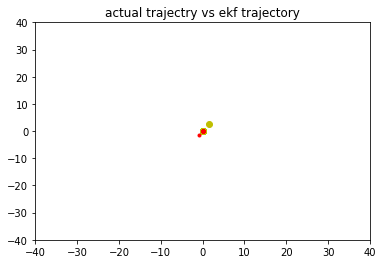

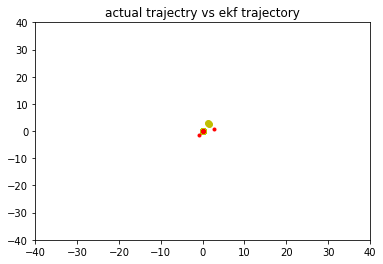

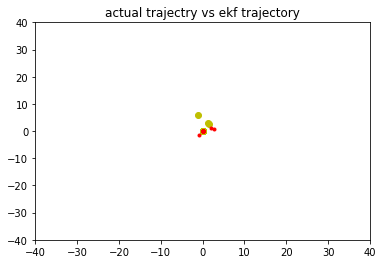

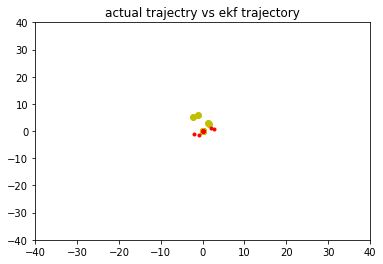

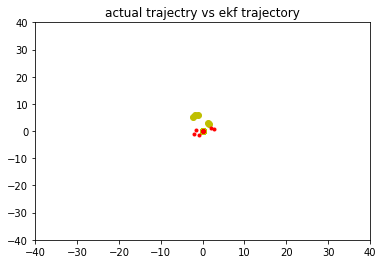

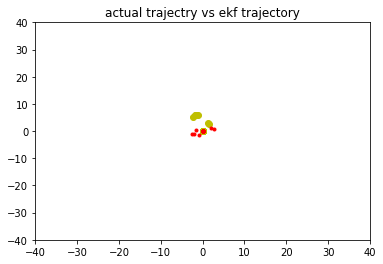

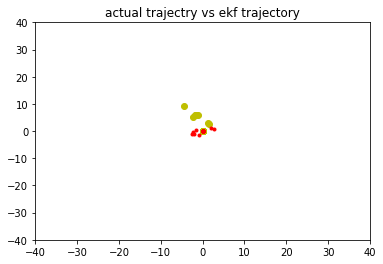

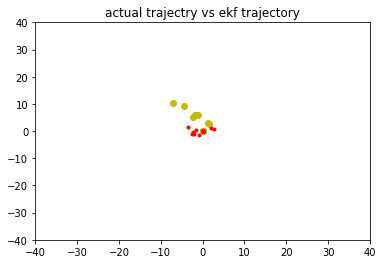

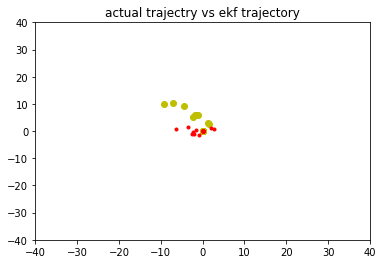

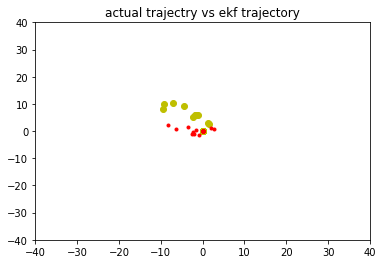

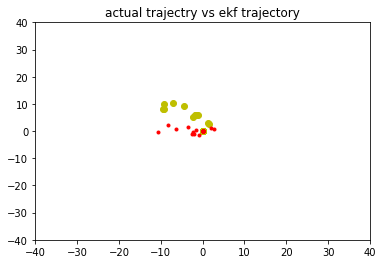

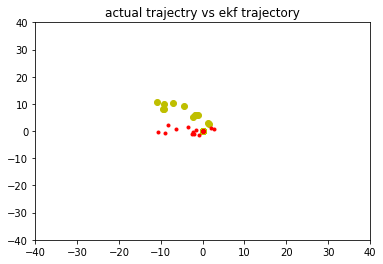

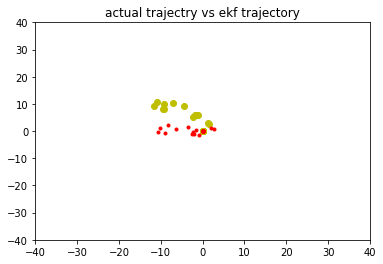

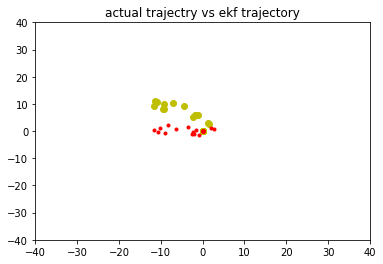

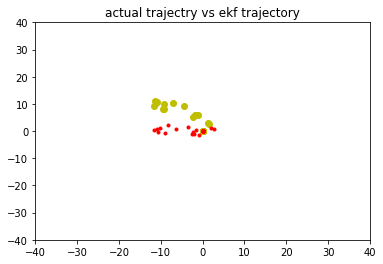

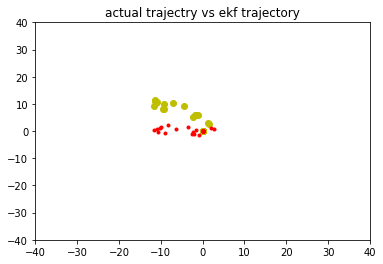

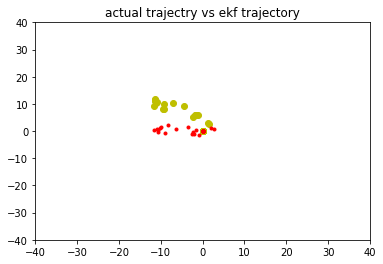

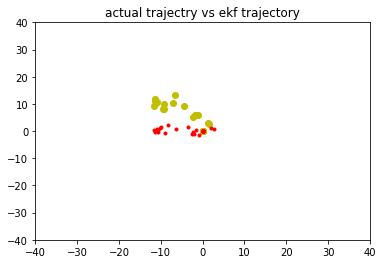

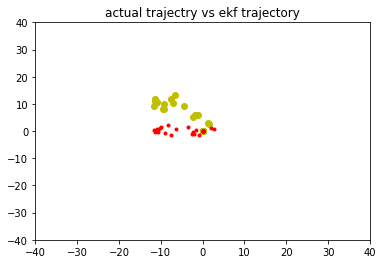

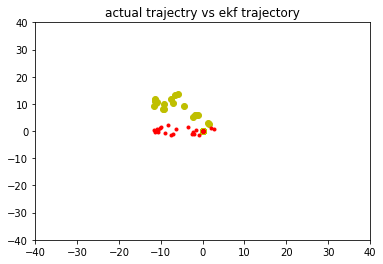

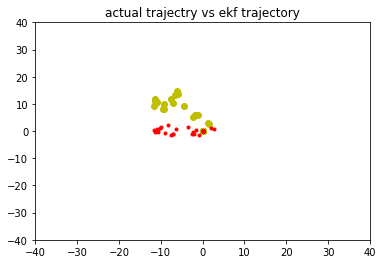

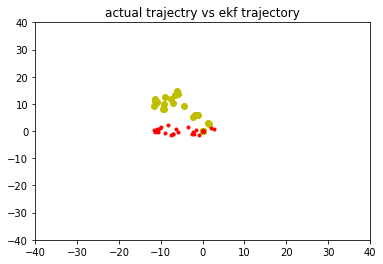

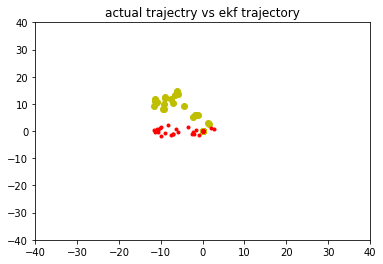

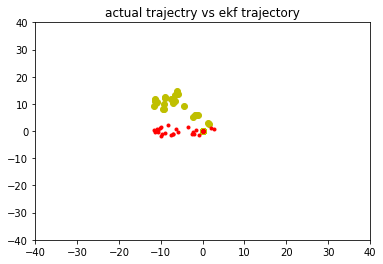

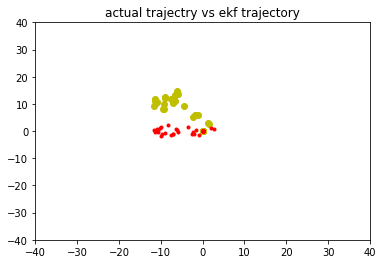

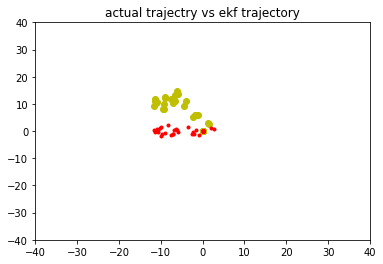

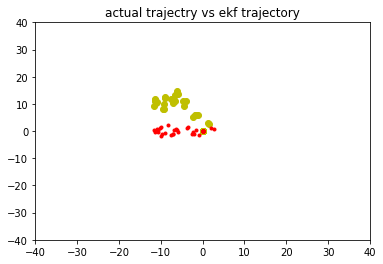

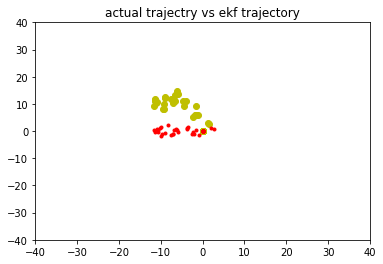

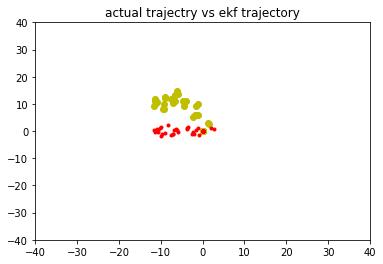

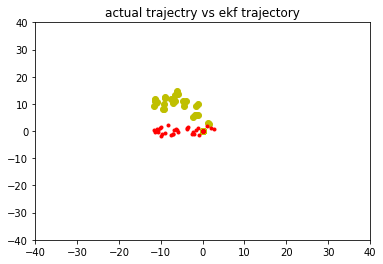

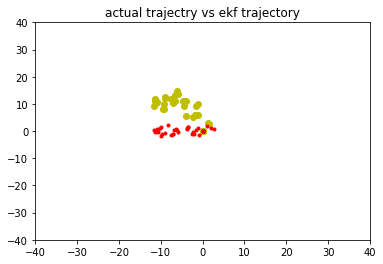

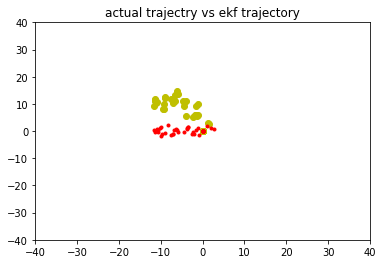

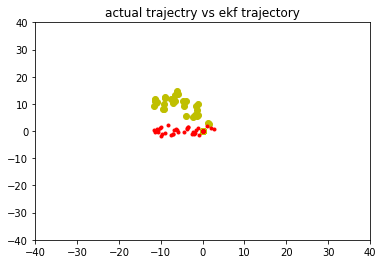

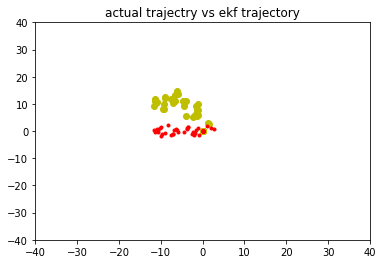

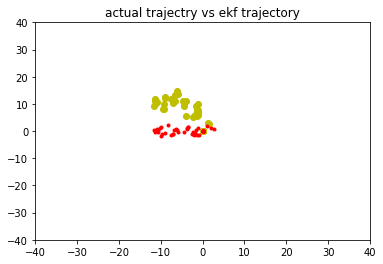

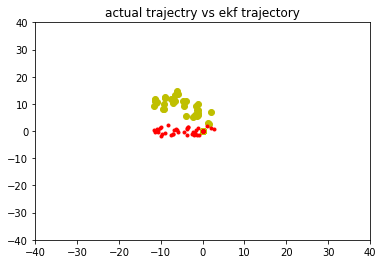

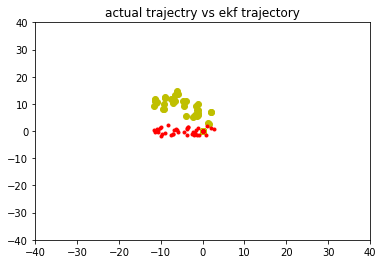

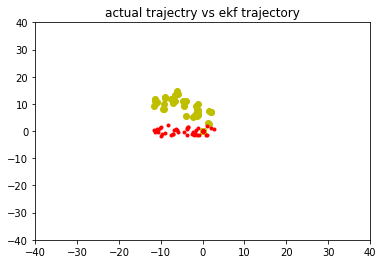

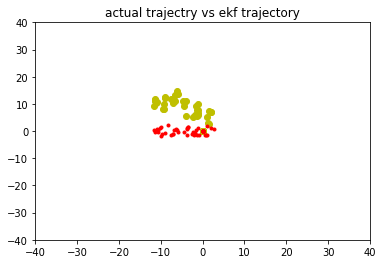

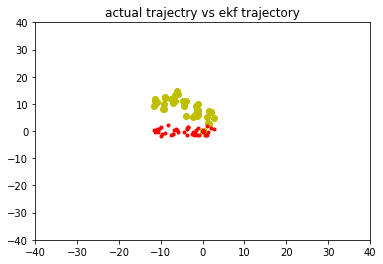

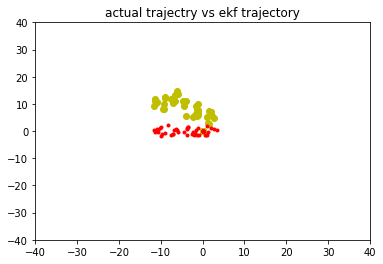

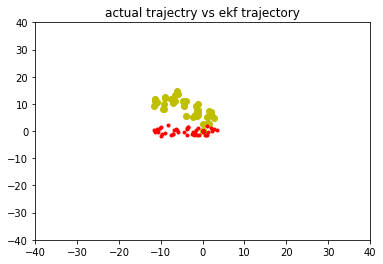

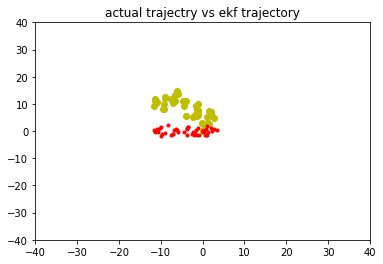

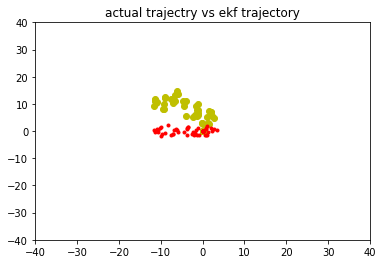

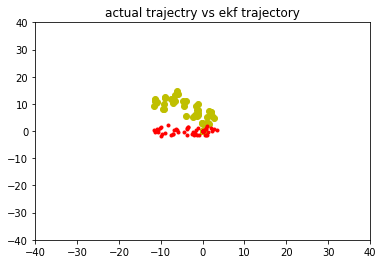

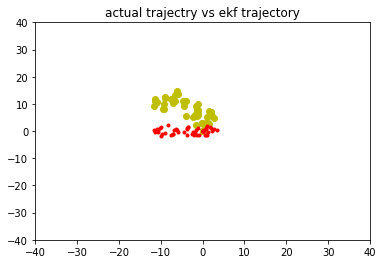

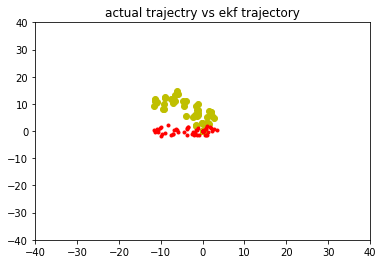

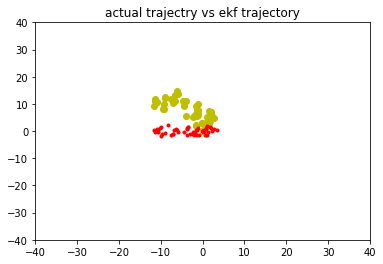

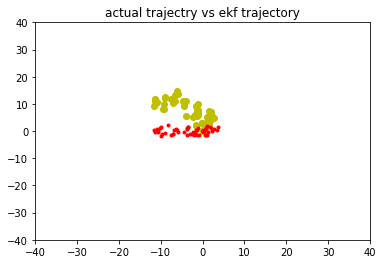

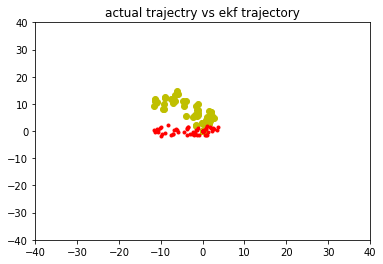

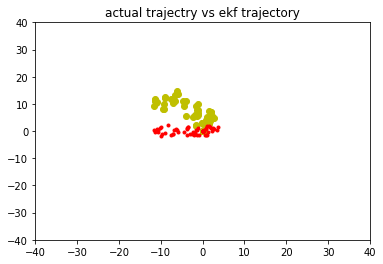

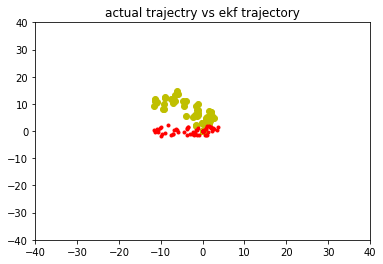

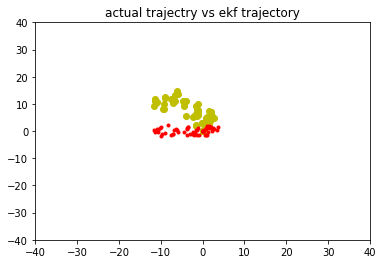

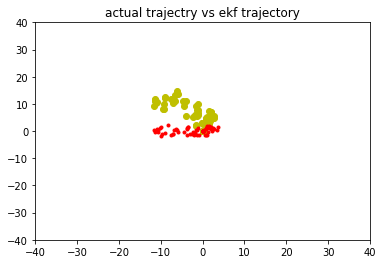

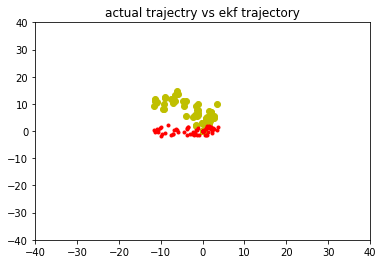

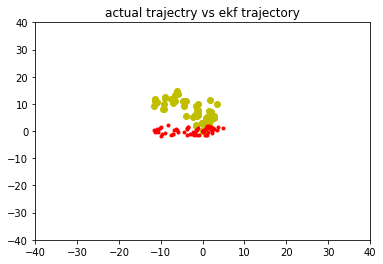

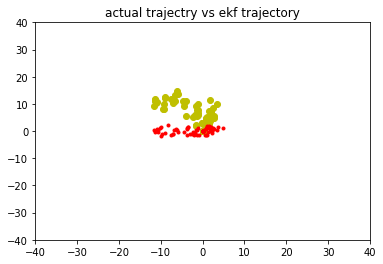

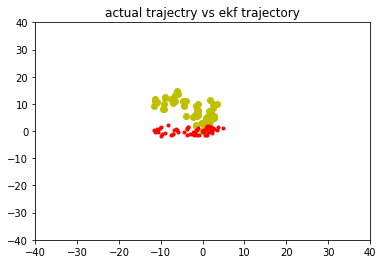

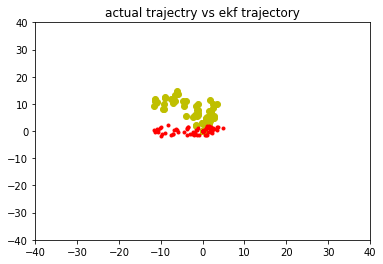

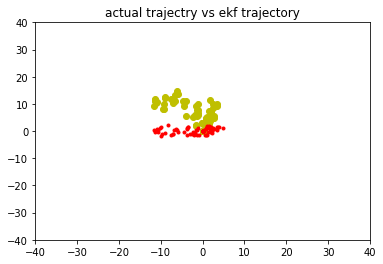

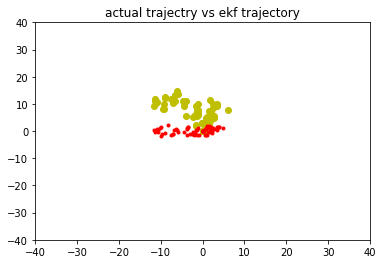

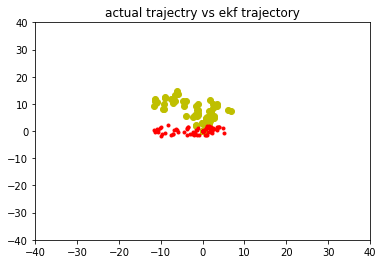

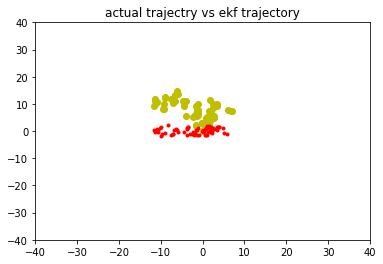

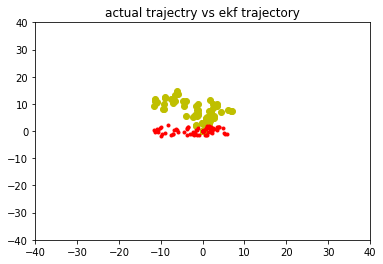

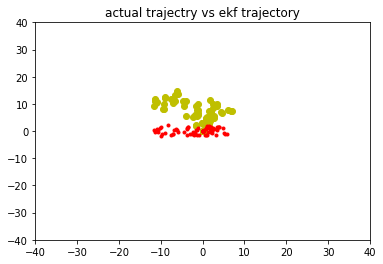

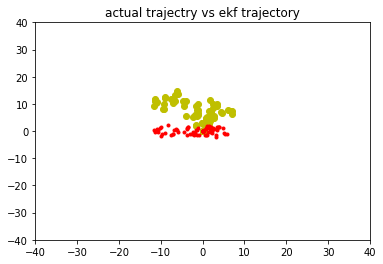

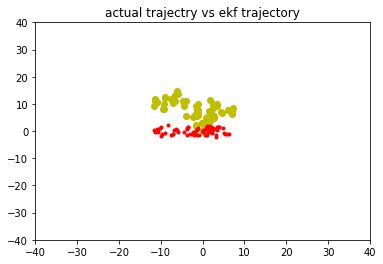

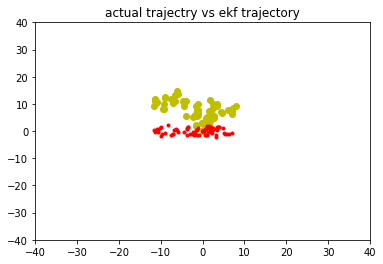

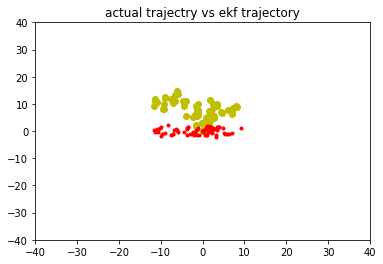

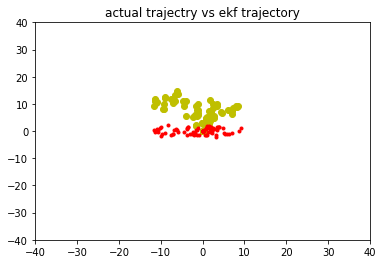

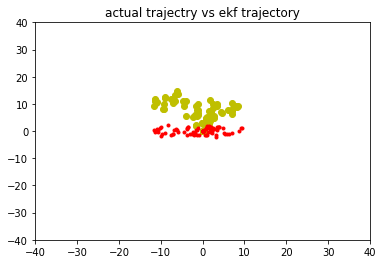

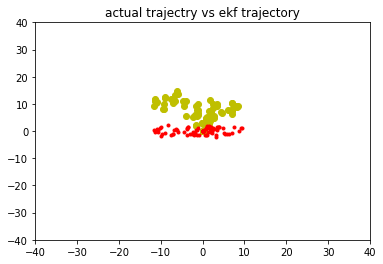

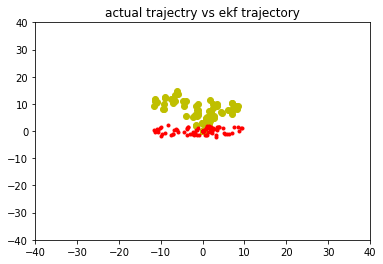

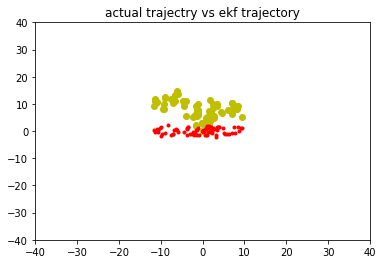

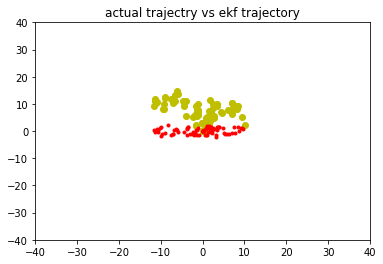

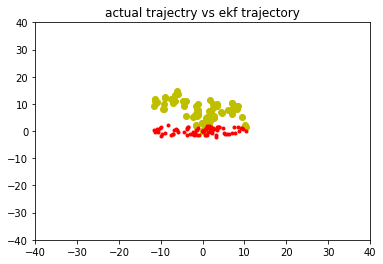

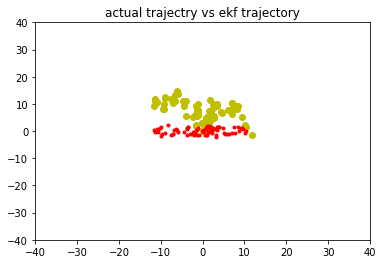

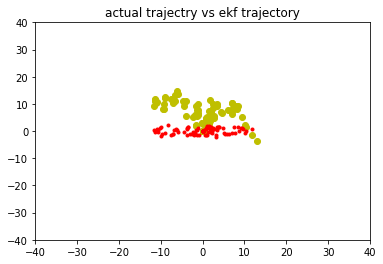

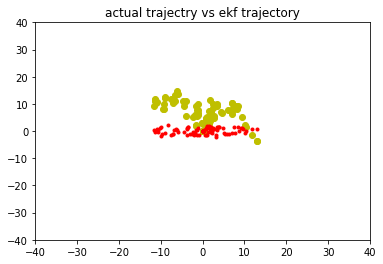

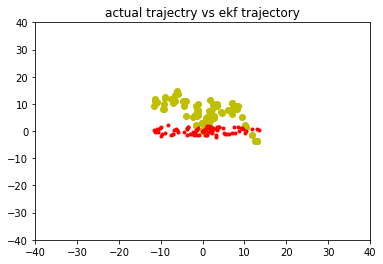

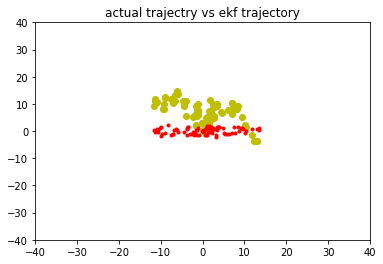

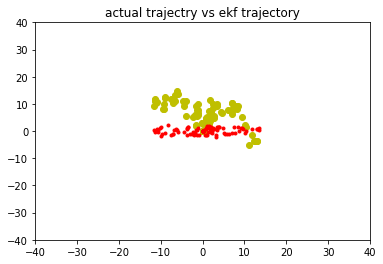

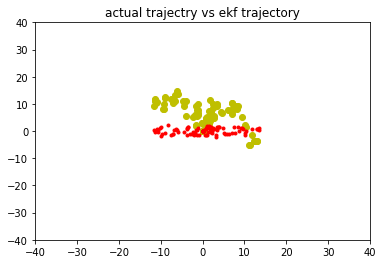

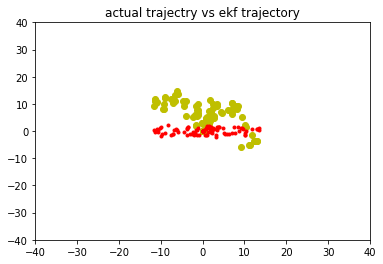

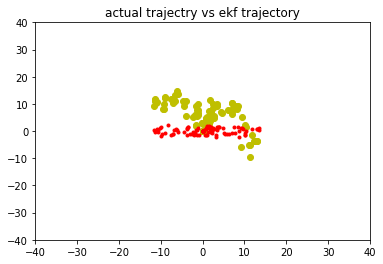

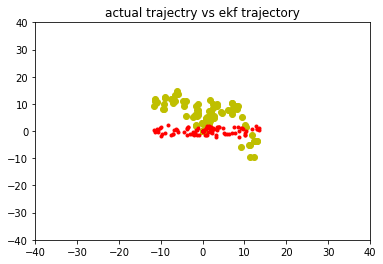

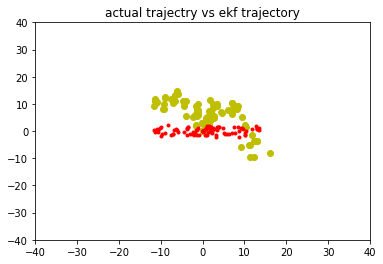

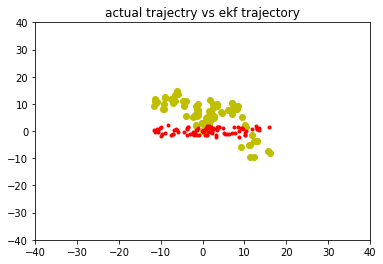

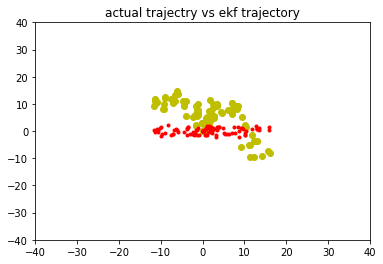

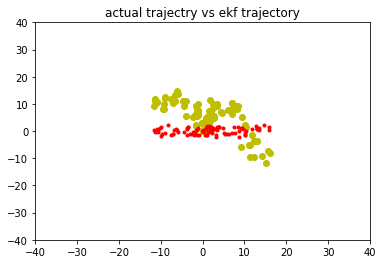

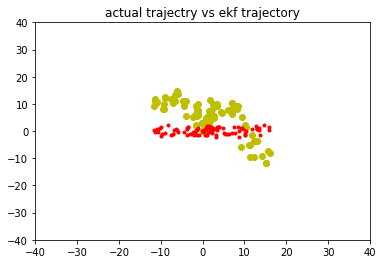

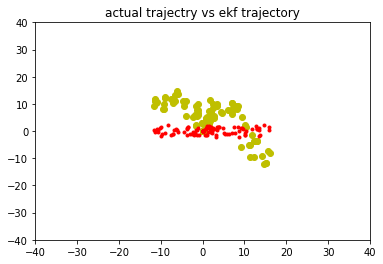

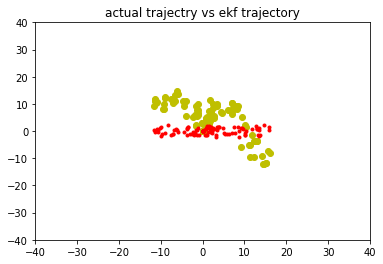

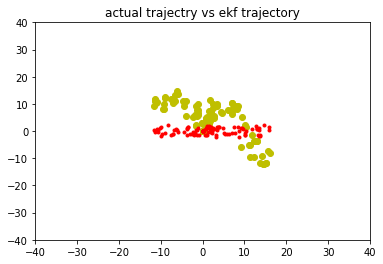

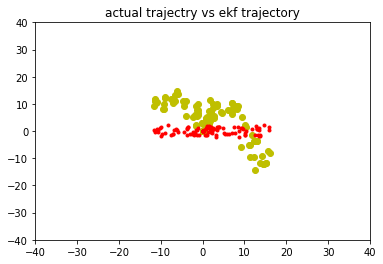

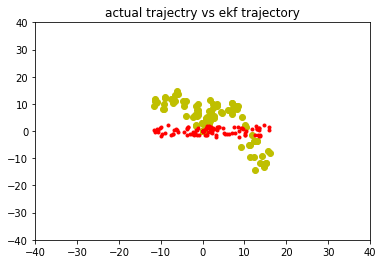

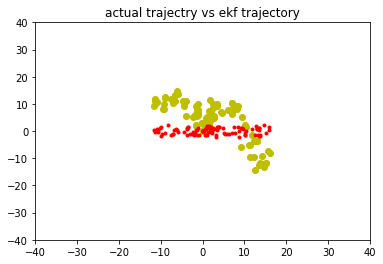

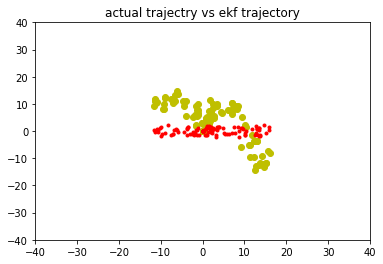

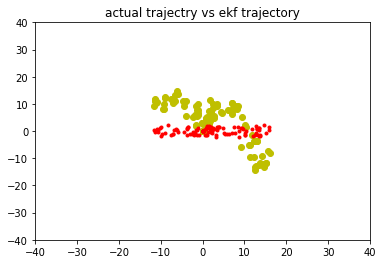

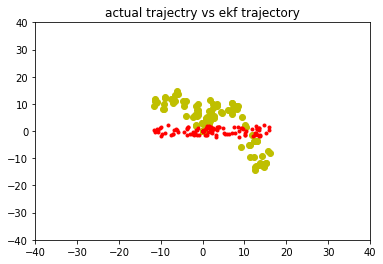

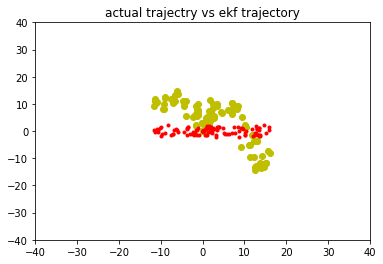

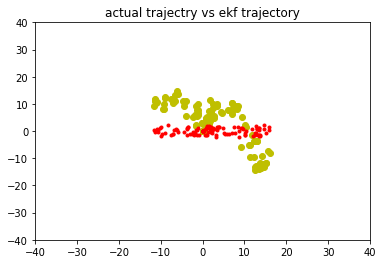

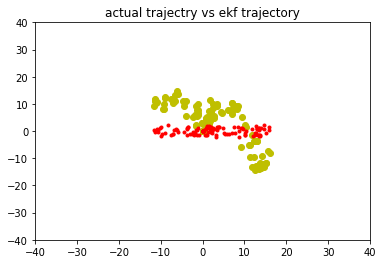

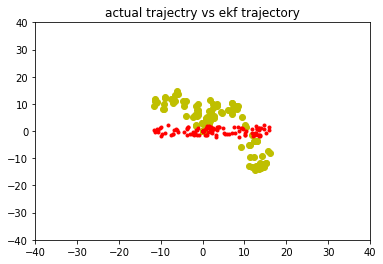

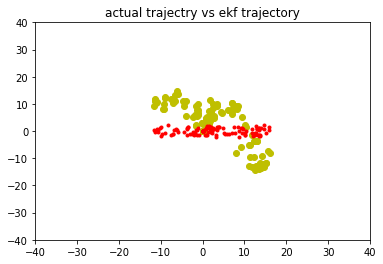

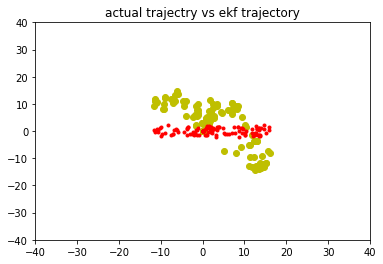

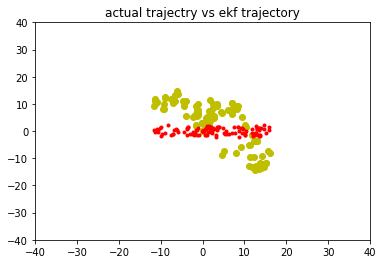

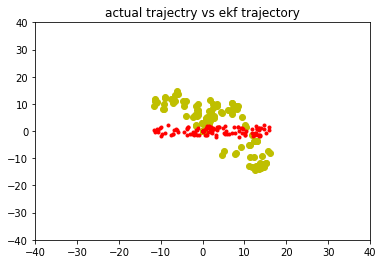

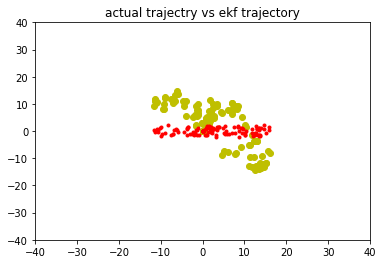

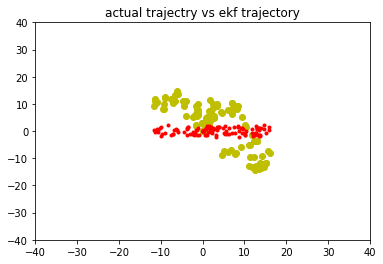

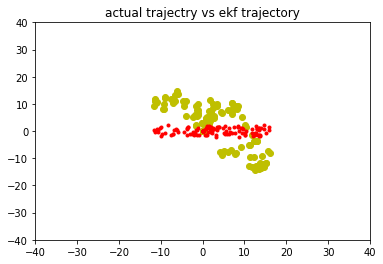

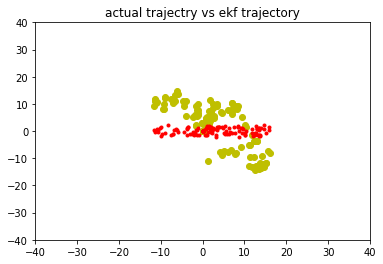

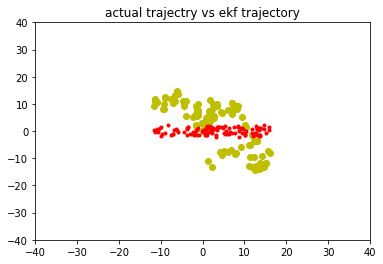

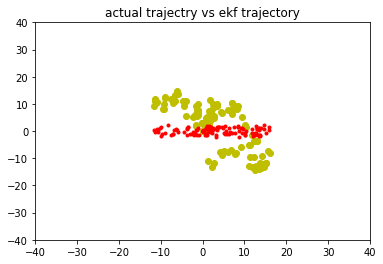

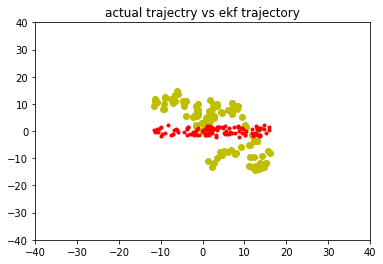

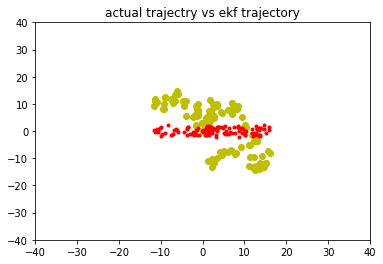

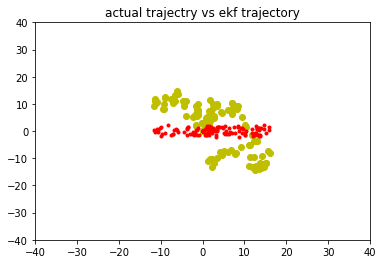

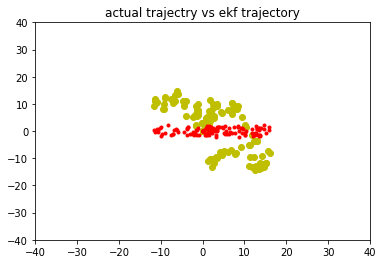

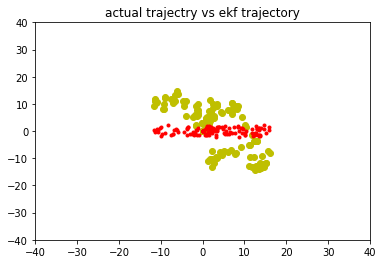

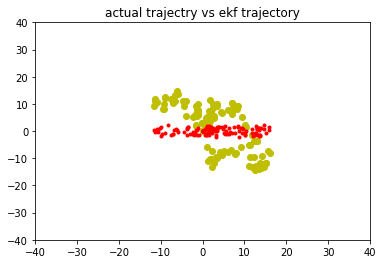

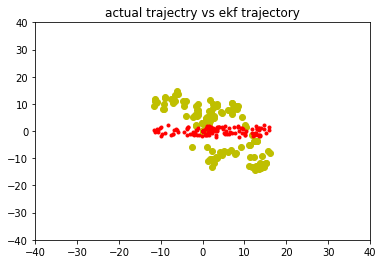

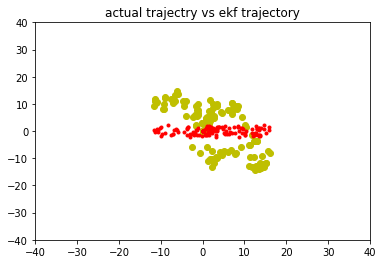

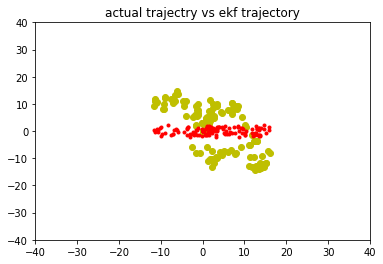

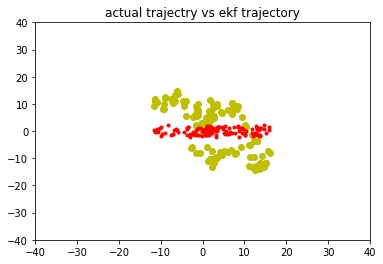

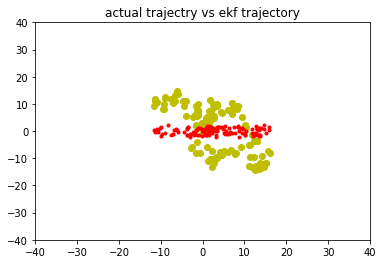

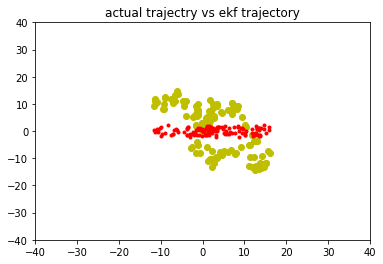

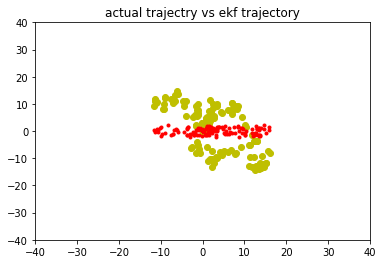

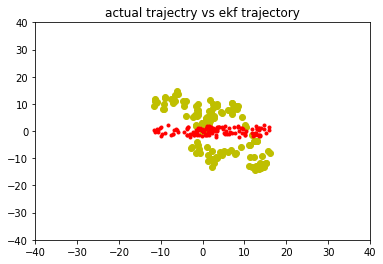

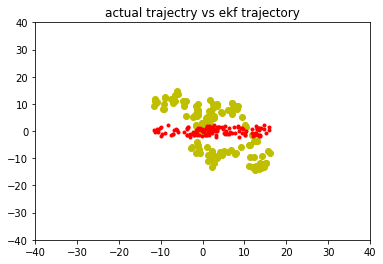

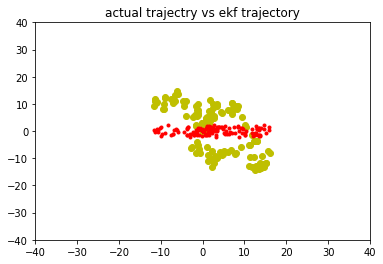

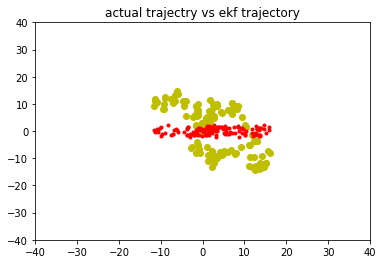

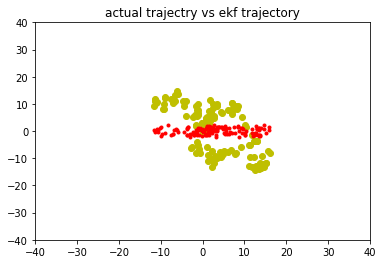

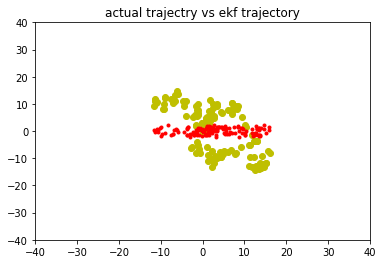

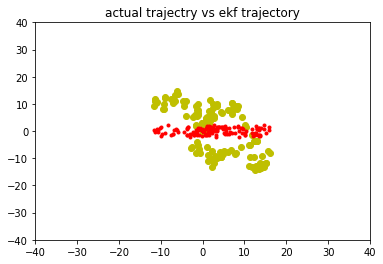

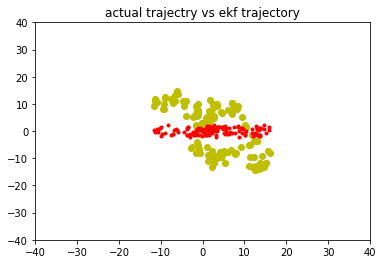

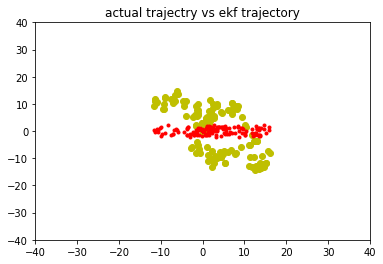

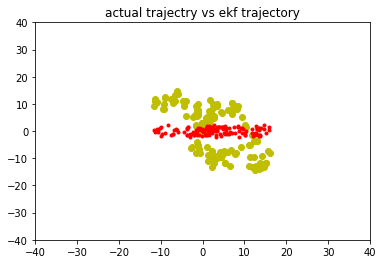

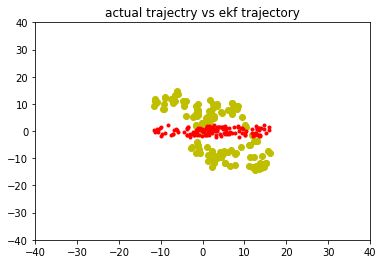

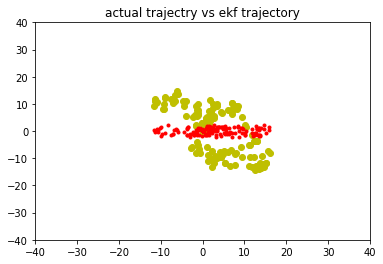

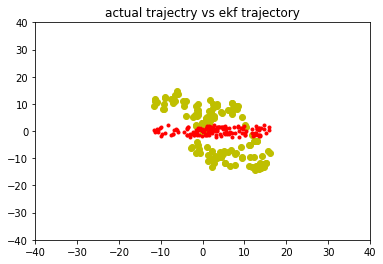

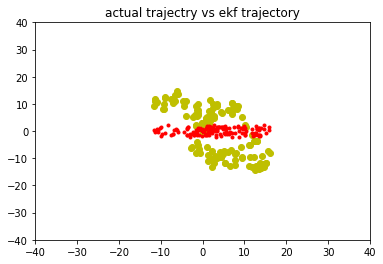

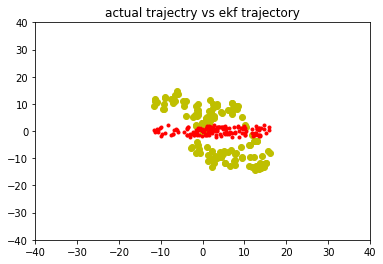

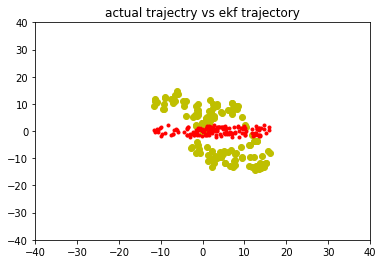

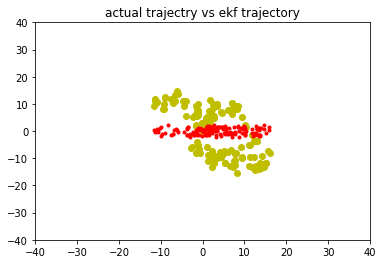

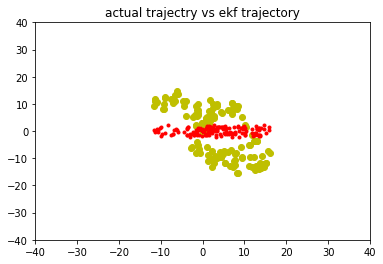

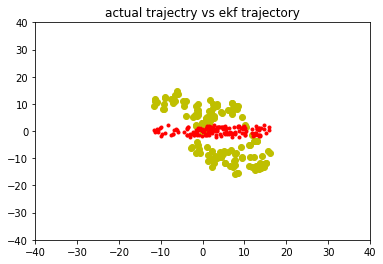

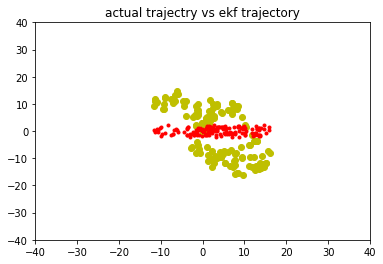

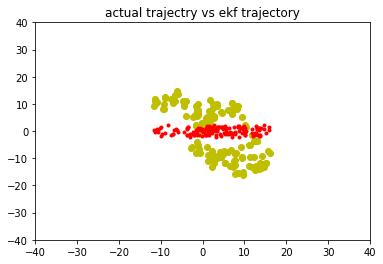

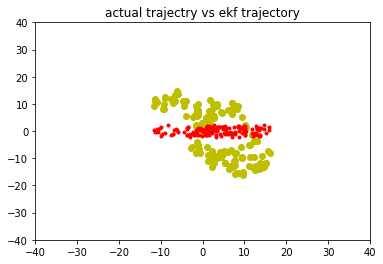

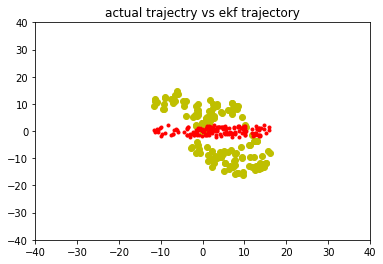

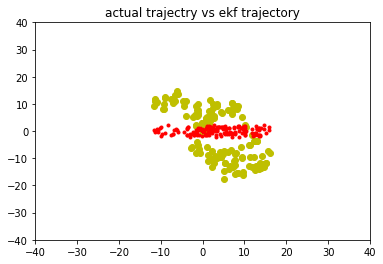

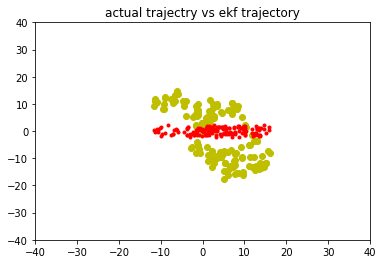

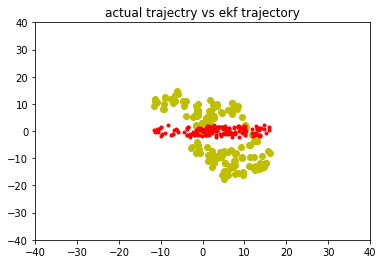

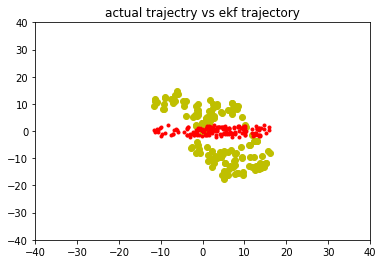

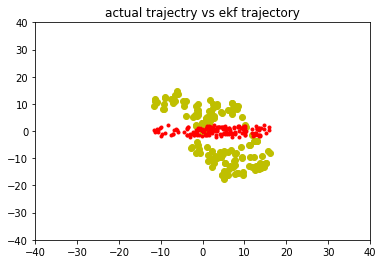

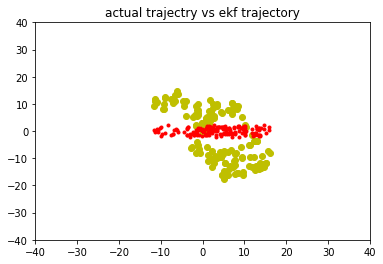

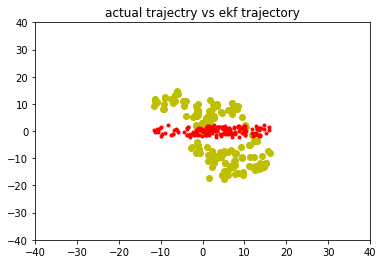

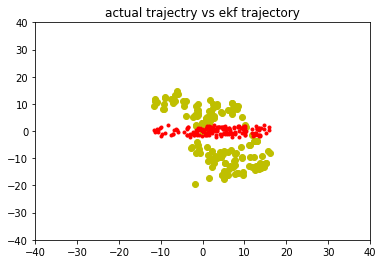

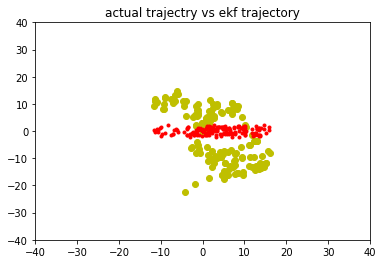

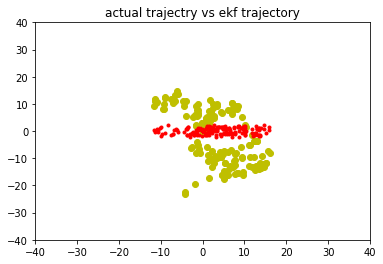

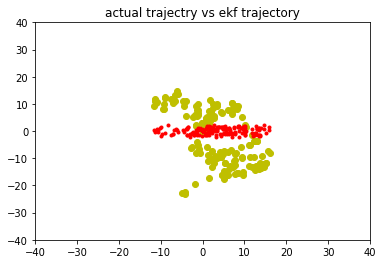

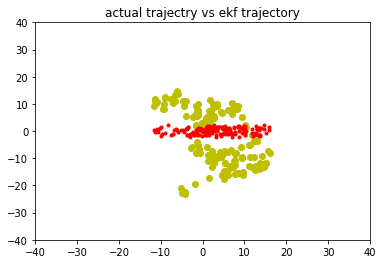

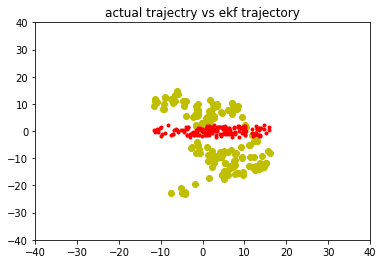

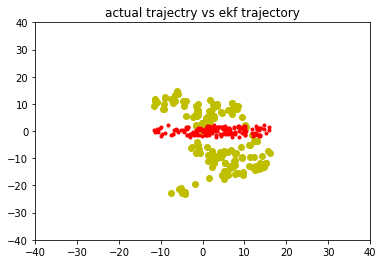

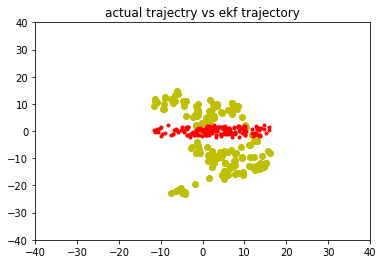

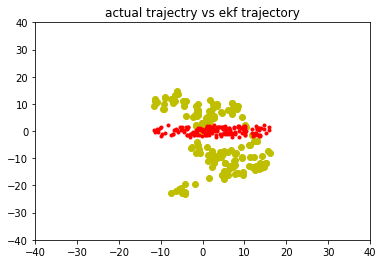

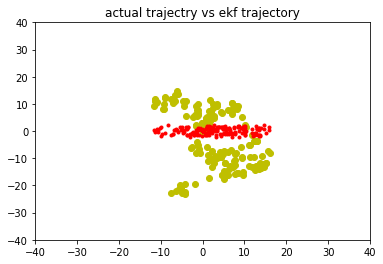

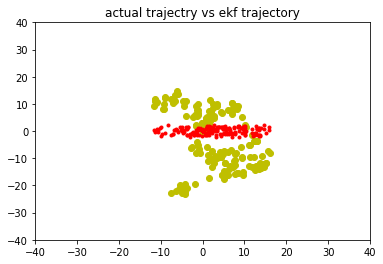

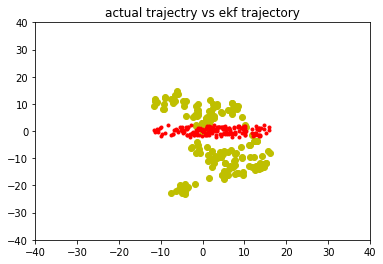

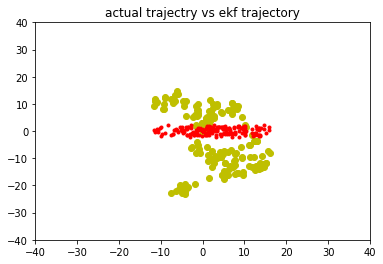

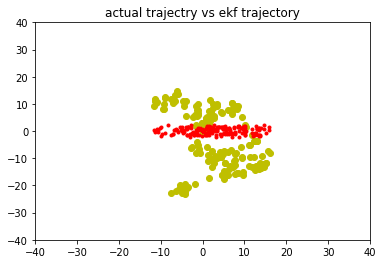

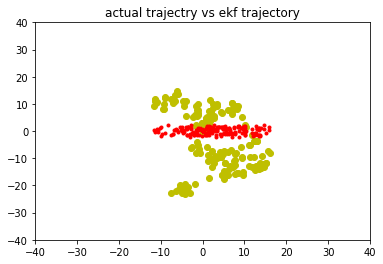

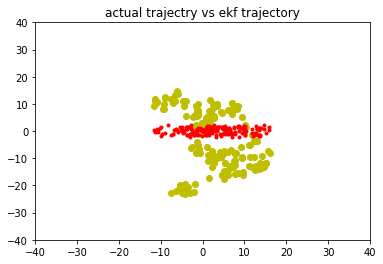

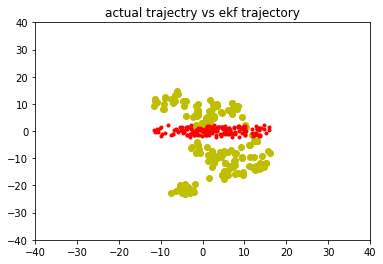

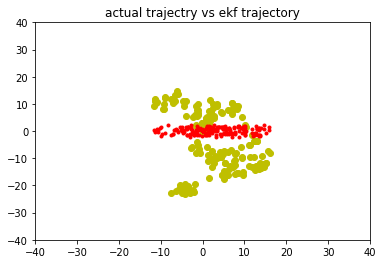

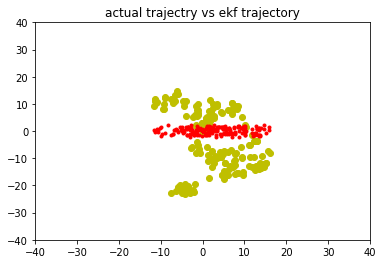

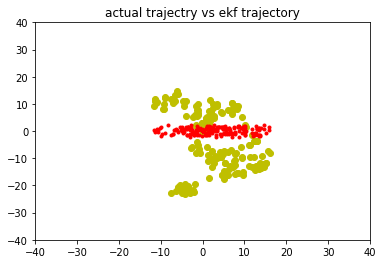

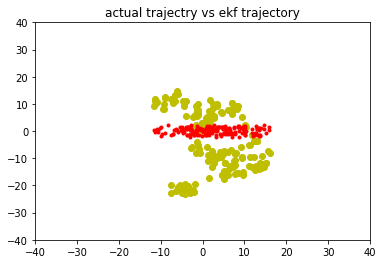

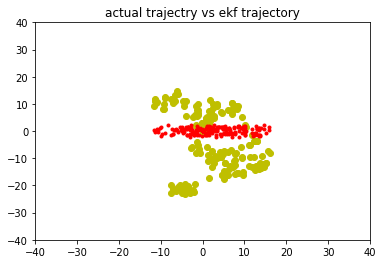

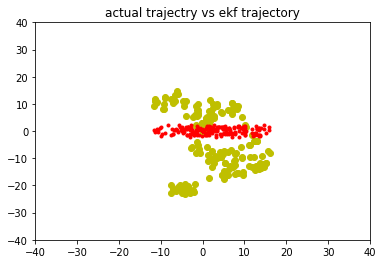

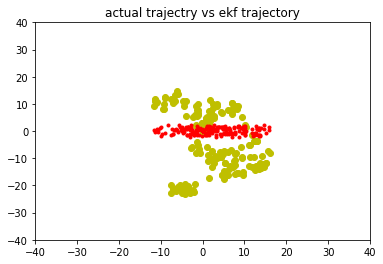

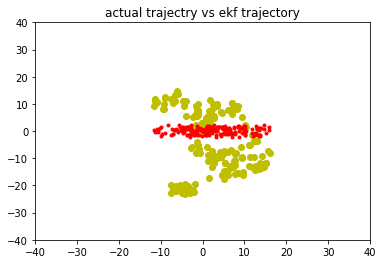

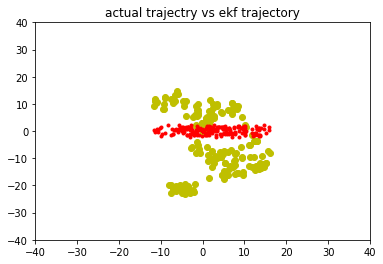

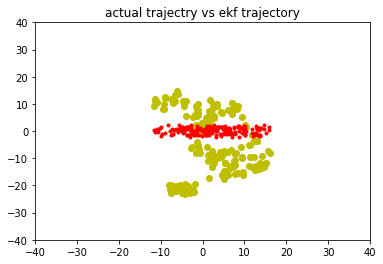

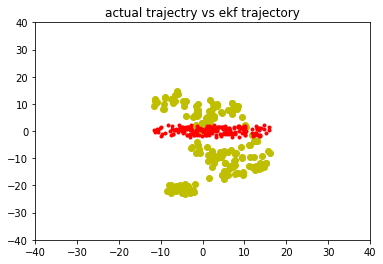

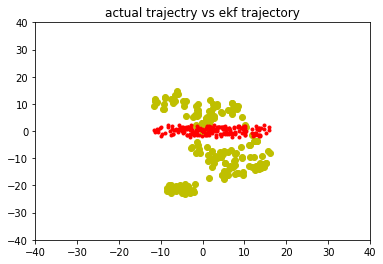

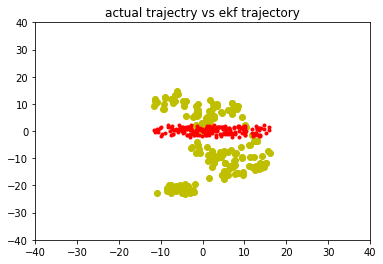

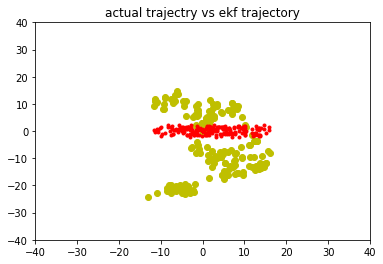

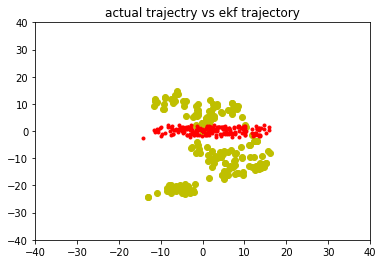

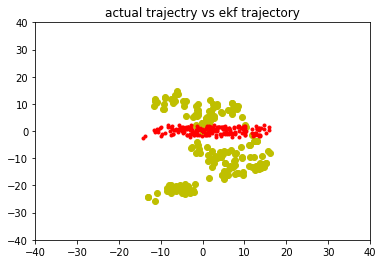

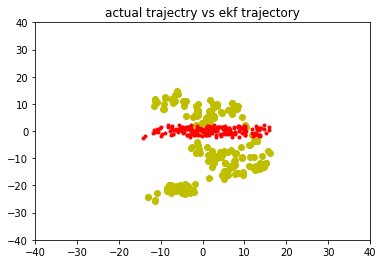

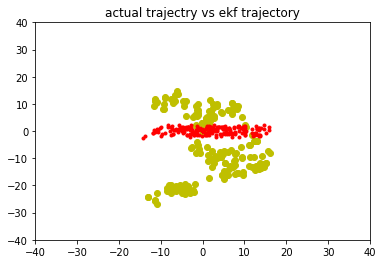

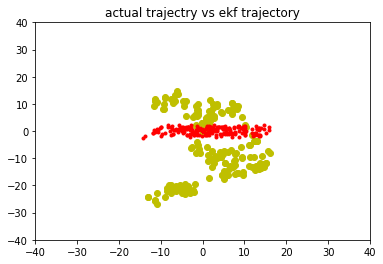

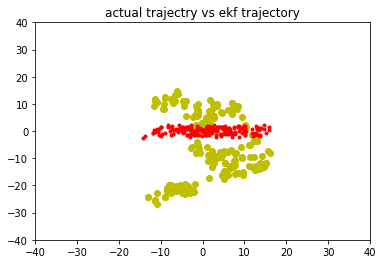

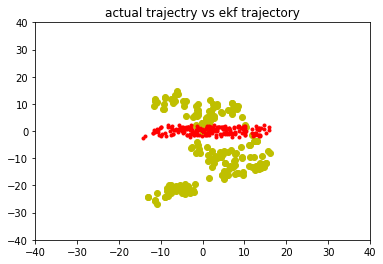

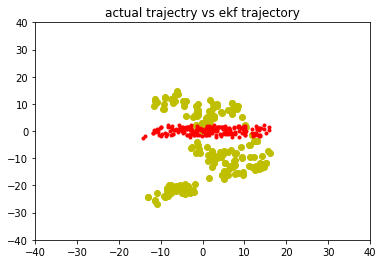

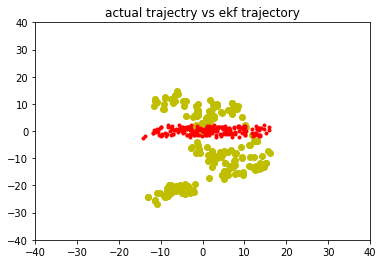

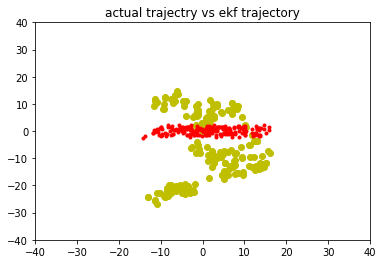

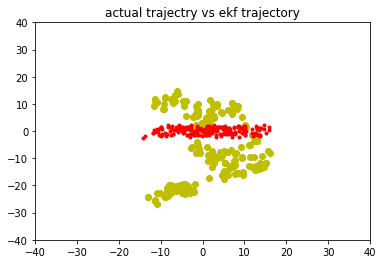

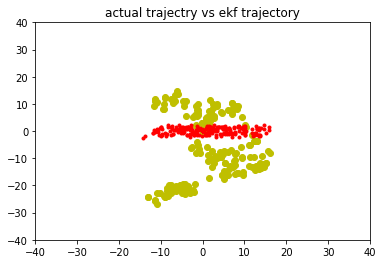

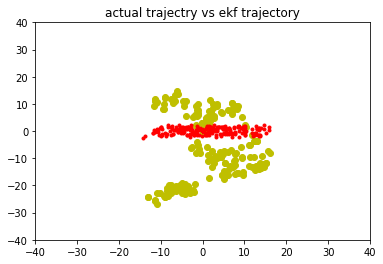

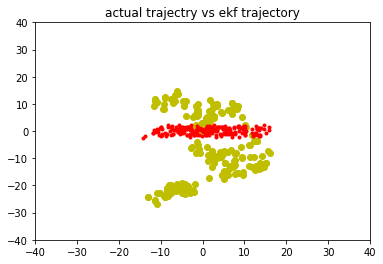

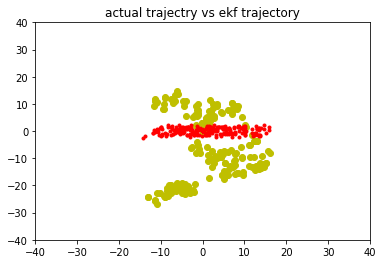

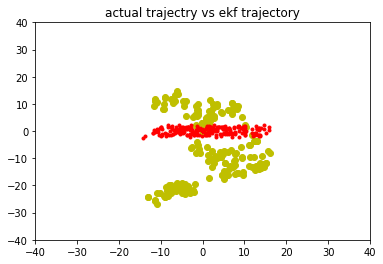

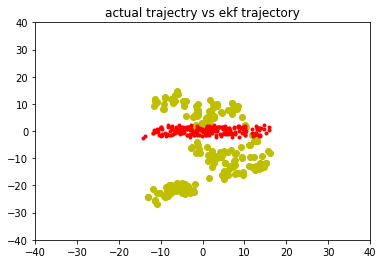

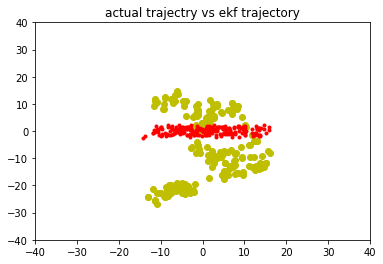

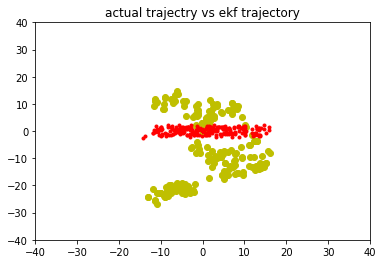

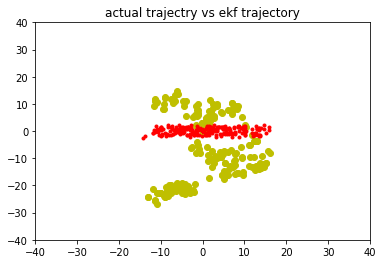

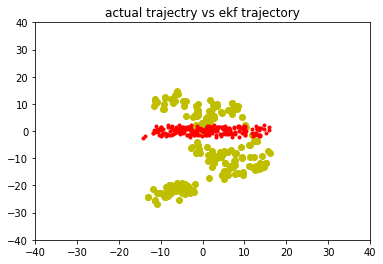

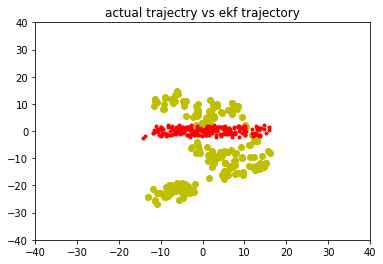

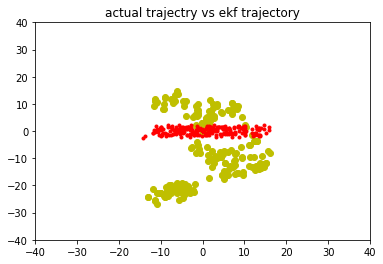

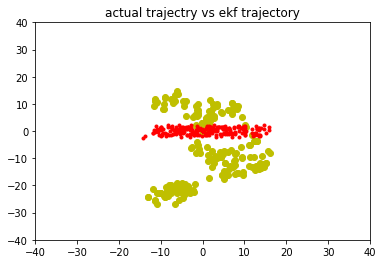

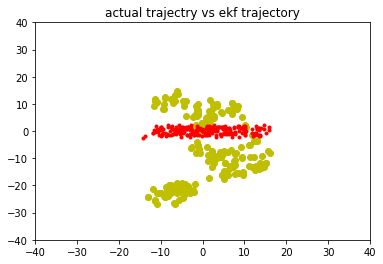

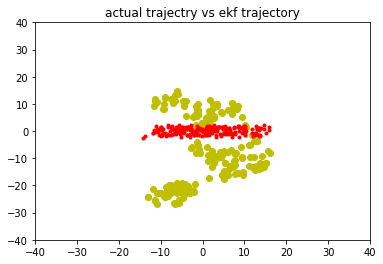

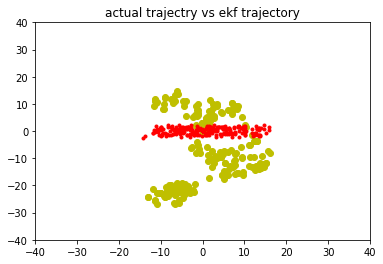

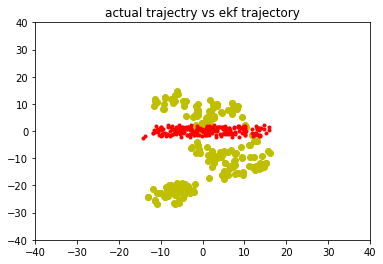

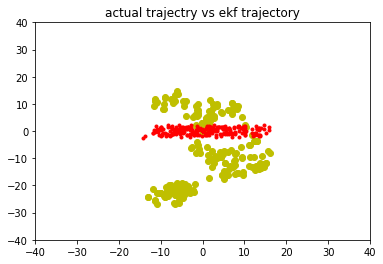

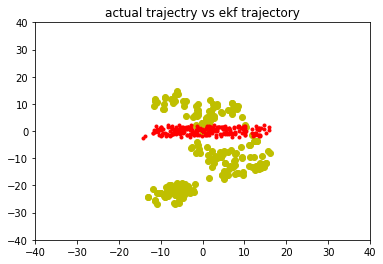

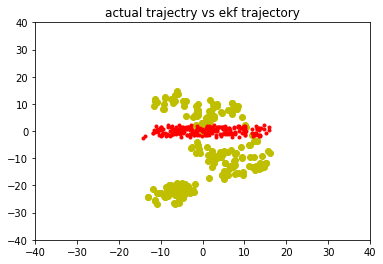

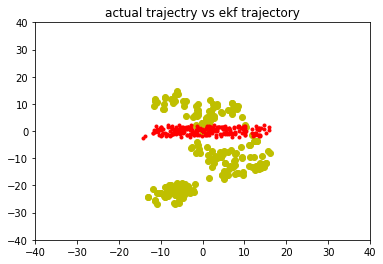

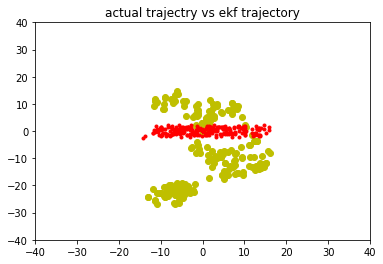

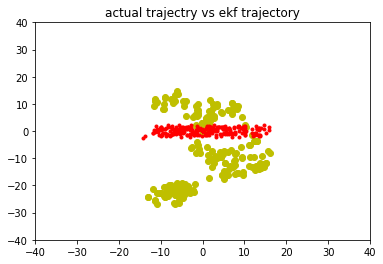

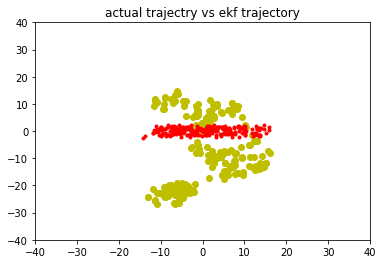

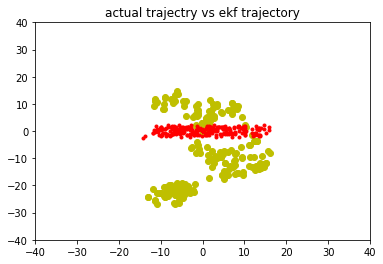

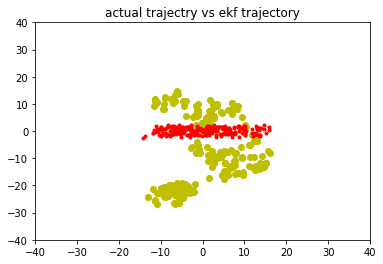

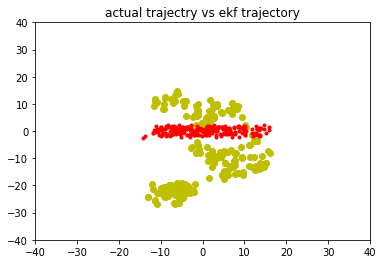

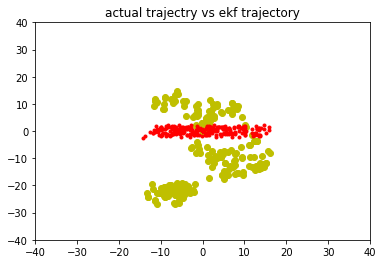

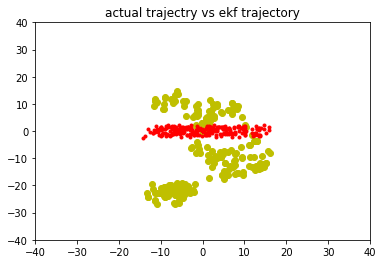

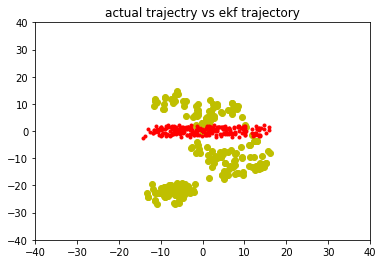

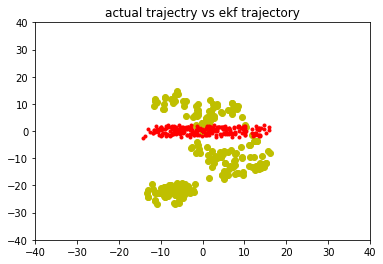

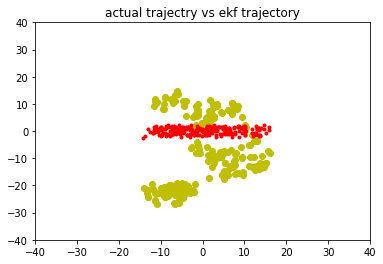

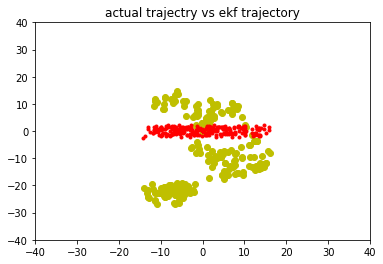

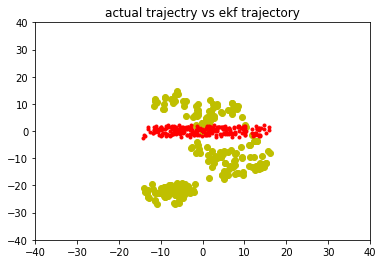

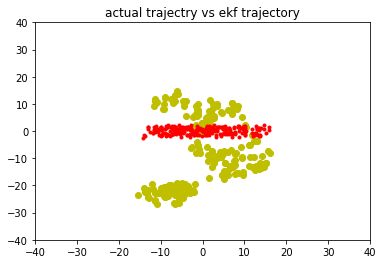

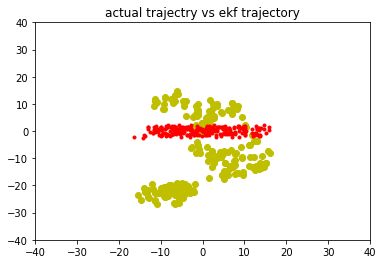

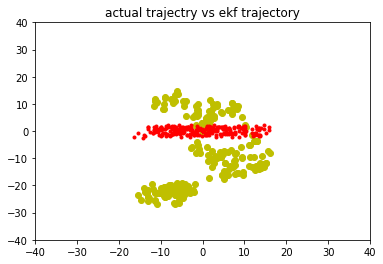

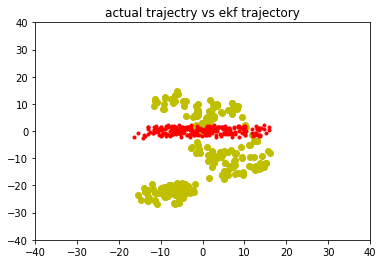

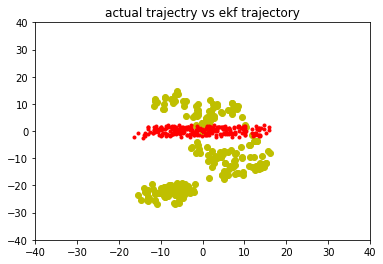

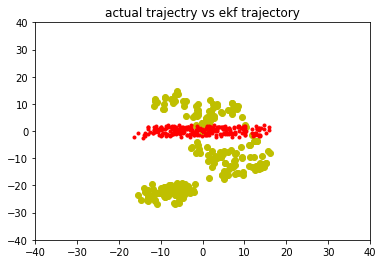

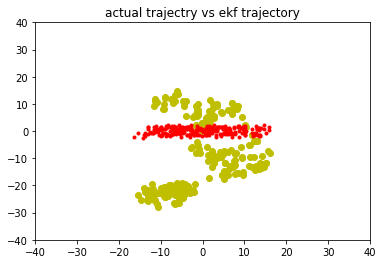

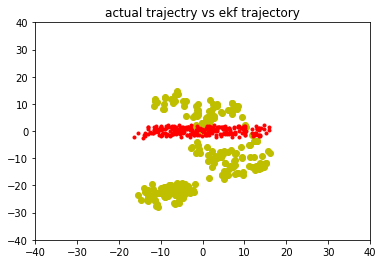

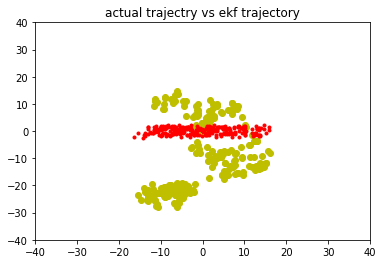

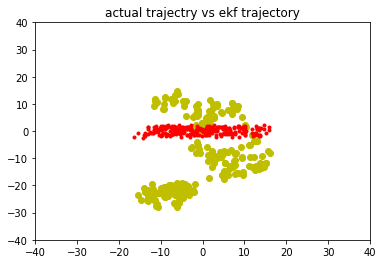

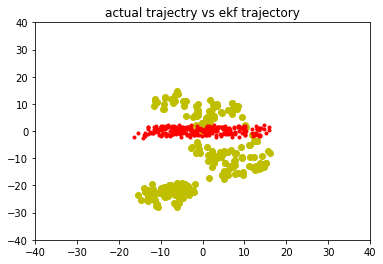

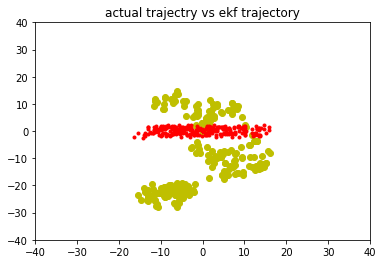

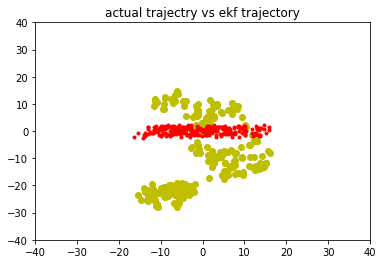

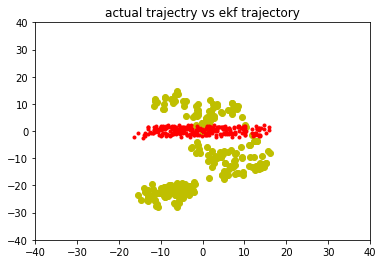

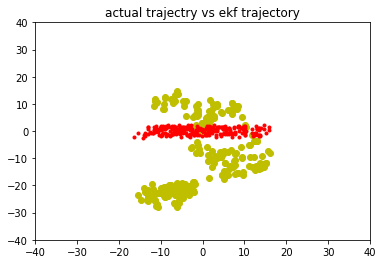

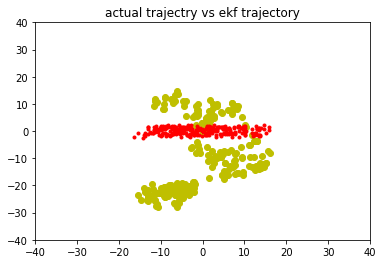

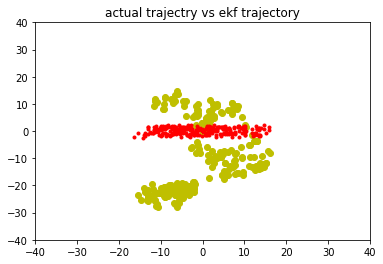

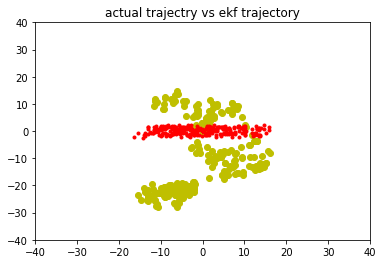

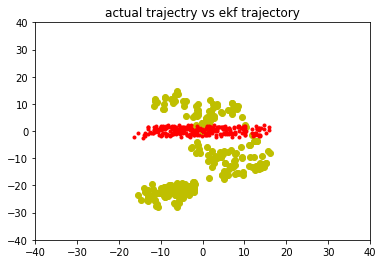

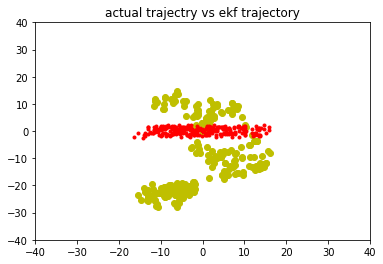

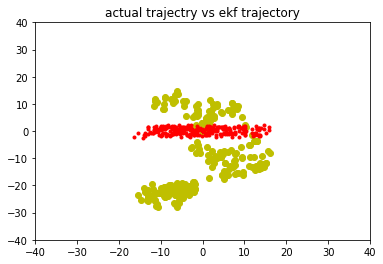

ZeroDivisionError: division by zero

<Figure size 432x288 with 0 Axes>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
#...................................................inspired from book, EKF_pose (code given in matlab) and notes.........

#............................................................given data.....................................

xinital = 50
yinital = 100
theta_inital = 0
T = 1000


#landmarks locations
l1 = np.array([0,0])
l2 = np.array([300,0])
l3 = np.array([600,0])
l4 = np.array([600,450])
l5 = np.array([300,450])
l6 = np.array([0,600])
landmarks = np.array([[l1],[l2],[l3],[l4],[l5],[l6]])
no_of_landmarks = len(landmarks)


pose = np.zeros((3,T))
pose[0,0] = xinital
pose[1,0] = yinital
pose[2,0] = theta_inital

u = np.zeros((3,T))
u_ = np.zeros((3,T))
Sigma_ = np.zeros((3,3,T))
Sigma = np.zeros((3,3,T))

#No noise  in initial estimate
mu_0 = np.array([0,0,0])
Sigma_0 = np.zeros((3,3))


#alpha parameters
alpha_1 = 0.2
alpha_2 = 0.2
alpha_3 = 0.2
alpha_4 = 0.2



#Q from the book
Q = np.array([[0.5, 0, 0],[0, 0.1, 0], [0, 0, 1]])


for i in np.arange(2,T+1).reshape(-1):
    
#linear velocity v(t) and angularvelocityω(t) wrt time

    if i >= 0 and i <= 250:
        u1 = 2
        u2 = 2
    elif i > 250 and i <= 255:
        u1 = 0.1
        u2 = 0.314
    elif i > 255 and i <= 405:
        u1 = 2
        u2 = 0
    elif i > 405 and i <= 410:
        u1 = 0.1
        u2 = 0.314
    elif i > 410 and i <= 610:
        u1 = 2
        u2 = 0
        
        
    #given control units with added noise
        
    sigma_x = (alpha_1 * u1 ** 2) + (alpha_2 * u2 ** 2)
    sigma_y = (alpha_3 * u1 ** 2) + (alpha_4 * u2 ** 2)
    
    u1_ = u1 + np.random.normal(0,sigma_x)
    u2_ = u2 + np.random.normal(0,sigma_y)
    
    
    
    #noisy pose
    pose[0,i] = pose[0,i - 1] - (u1_ / u2_) * np.sin(pose[2,i - 1]) + (u1_ / u2_) * np.sin(pose[2,i - 1] + u2_)
    pose[1,i] = pose[1,i - 1] + (u1_ / u2_) * np.cos(pose[2,i - 1]) - (u1_ / u2_) * np.cos(pose[2,i - 1] + u2_)
    pose[2,i] = pose[2,i - 1] + u2_
    
    
    
    # considering motion model without noise for linearization
    g = pose[0,i - 1] - np.array([[(u1 / u2) * np.sin(pose[1,i - 1]) + (u1 / u2) * np.sin(pose[1,i - 1] + u2)],[pose[0,i - 1] + (u1 / u2) * np.cos(pose[1,i - 1]) - (u1 / u2) * np.cos(pose[1,i - 1] + u2)],[pose[1,i - 1] + u2]])
    u_[:,[i]] = g
    
    
    #G
    G = np.array([[1, 0, (u1 / u2) * (- np.cos(pose[2,i - 1])) + (u1 / u2) * (np.cos(pose[2,i - 1] + u2))],[0 , 1, - (u1 / u2) * (np.sin(pose[2,i - 1])) + (u1 / u2) * (np.sin(pose[2,i - 1] + u2))],[0,0,1]])
   
    
    #Mt
    Mt = np.array([[sigma_x,0],[0,sigma_y]])
    
    
    
    #Vt
        
    Vt = np.array([[(-np.sin(pose[2,i - 1]) + np.sin(pose[2,i - 1] + u2))/u2, 
     ((u1 * (np.sin(pose[2,i - 1]) - np.sin(pose[2,i - 1] + u2))) / u2**2) + ((u1 * np.cos(pose[2,i - 1] + u2)) / u2)], 
    [((np.cos(pose[2,i - 1]) - (np.cos(pose[2,i - 1] + u2))) / u2),
     ((- u1 * (np.cos(pose[2,i - 1]) - np.cos(pose[2,i - 1] + u2))) / u2 ** 2) + ((u1 * np.sin(pose[2,i - 1] + u2)) / u2)],[0,1]])

    
    # R
    R = np.matmul(np.matmul(Vt,Mt),(np.transpose((Vt))))
    
    
    
    #sigma_
    temp = np.matmul(G,Sigma[:,:,i - 1])
    Sigma_[:,:,i] = np.matmul(temp,np.transpose(G)) + R
    
    

    for landmark in range(no_of_landmarks):
        
        
        #z_
        lm = landmarks[landmark,:]
        q = ((lm[0,0] - g[0,0]) ** 2 + (lm[0,1] - g[1,0]) ** 2)
        Ph = math.atan2(lm[0,1] - g[1,0],lm[0,0] - g[0,0] - g[2,0])
        z_ = np.array([[np.sqrt(q)],[Ph],[0]])
        r = np.sqrt(q)

        
        #z with s =0
        z = np.array([[r + np.random.normal(0,0.5)],[Ph + np.random.normal(0,0.1)],[0]])
        
        
        
        #H
        H = np.array([[- (lm[0,0] - g[0,0]) / r,- (lm[0,1] - g[1,0]) / r,0],[(lm[0,1] - g[1,0]) / q,- (lm[0,0] - g[0,0]) / q,- 1],[0,0,0]])
        
        
        #S
        S1 = (np.matmul((H),(Sigma_[:,:,i])))
        S = np.matmul(S1,np.transpose(H)) + Q      

        
        #k
        K = np.matmul(np.matmul(Sigma_[:,:,i],np.transpose(H)), np.linalg.inv(S))
        
        
        #updated u_
        u_[:,[i]] = u_[:,[i]] + np.matmul(K, ((z - z_)))
        
        #sigma_
        Sigma_[:,:,i] = np.matmul((np.eye(3) -((np.matmul(K,H)))), Sigma_[:,:,i])
        
        
     #update u   
    u[:,i] = u_[:,i]
     #update sigma
    Sigma[:,:,i] = Sigma_[:,:,i]
    
    
    plt.figure(1)    
    plt.plot(pose[0,:],pose[1,:],'y.', marker='o')
    plt.plot(u_[0,:],u_[1,:],'r.')
    plt.axis(np.array([- 40,40,- 40,40]))
    plt.title('actual trajectry vs ekf trajectory')

    plt.draw()
    plt.pause(0.0001)
    plt.clf()


In [ ]:
np.eye(3)

In [ ]:
K

In [ ]:
 mu_bar[:,i] + K * (z - z_hat)